Plotting infection circles...


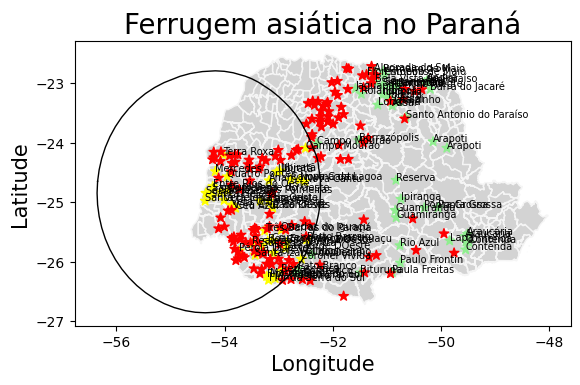

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

mapa = gpd.read_file('../Data/Maps/PR_Municipios_2021/PR_Municipios_2021.shp')
coletores = pd.read_csv('../Data/Collectors/2021/ColetoresSafra2122.csv', sep=';', decimal=',', parse_dates=['Data_1o_Esporos'], infer_datetime_format=True).sort_values(by='Data_1o_Esporos')

coletores.index = range(0, len(coletores))

def coloring():
    
    global first_apperances

    coletores['color'] = coletores['Situacao'].apply(lambda x: 'lightgreen' if x == 'Com esporos' else 'red')
    first_apperances = coletores[coletores['Data_1o_Esporos'] == coletores['Data_1o_Esporos'].min()]

    for i in first_apperances.index:
        coletores.loc[i, 'color'] = 'yellow'

def growth(number_of_days=200):

    global infection_circles

    infection_circles = []

    for i in range(len(first_apperances)): # For each starting point

        infection_circle = Point(first_apperances['Longitude'].iloc[i], first_apperances['Latitude'].iloc[i]).buffer(0.01 * 1) # Create a new infection circle
        infection_circles.append([i, infection_circle, 1]) # Add the infection circle to the list
        
    for day in range(number_of_days): # For each day

        for infection_circle_index in range(len(infection_circles)): # For each infection circle

            for collector_index in range(len(coletores)): # For each collector

                current_color = coletores['color'].iloc[collector_index]

                if current_color == 'yellow' or current_color == 'red': # Prevent re-infection and collectors that don't have spores
                    continue
                else:
                    if infection_circles[infection_circle_index][1].contains(Point(coletores['Longitude'].iloc[collector_index], coletores['Latitude'].iloc[collector_index])):
                        coletores.loc[collector_index, 'color'] = 'yellow'
                        new_buffer = 1
                        new_infection_circle = Point(coletores['Longitude'].iloc[collector_index], coletores['Latitude'].iloc[collector_index]).buffer(0.01 * new_buffer)
                        infection_circles.append([collector_index, new_infection_circle, new_buffer])

        for infection_circle_index in range(len(infection_circles)): # For each day passed, the infection circle grows
            infection_circles[infection_circle_index][2] += 1
            infection_circles[infection_circle_index][1] = Point(infection_circles[infection_circle_index][1].centroid.x, infection_circles[infection_circle_index][1].centroid.y).buffer(0.01 * infection_circles[infection_circle_index][2])

def plot_infection_circles():

    print("Plotting infection circles...")

    i = 0
    j = 1

    while i < len(infection_circles):
        while j < len(infection_circles):
            if infection_circles[i][1].intersects(infection_circles[j][1]):
                infection_circles[i][1] = infection_circles[i][1].union(infection_circles[j][1])
                infection_circles.pop(j)
            else:
                j += 1
        i += 1
        j = i + 1

    for i in range(len(infection_circles)):
        plt.plot(*infection_circles[i][1].exterior.xy, color='black', linewidth=1)

def plotting():

    # Map plot
    mapa.plot(color='lightgrey', edgecolor='whitesmoke')

    # Title and labels definitions
    plt.title('Ferrugem asiática no Paraná', fontsize=20)
    plt.xlabel('Longitude', fontsize=15)
    plt.ylabel('Latitude', fontsize=15)
    
    for i in range(len(coletores)):
        if coletores.loc[i, 'Situacao'] == 'Com esporos':
            plt.annotate(coletores['Municipio'][i], (coletores['Longitude'][i], coletores['Latitude'][i]), fontsize=7)

    plot_infection_circles()

    plt.scatter(coletores['Longitude'], coletores['Latitude'], color=coletores['color'], s=50, marker='*')

    plt.show()

coloring()
growth()
plotting()